<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session9/EVA7_Assignment9_AbhinavP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA 7 - S9 - Assignment - ResNets & Higher Receptive Fields

## Submission by Abhinav Pujahari (abhinavpujahari@gmail.com)

## Goals:
1. Write custom ResNet architecture for CIFAR 10
2. Use LR search to find optimal learning rate
3. Use OneCycle LR scheduling with LR max and min found from the previous step
4. Train for 24 Epochs in total with max LR reached at the 5th Epoch
5. Use padding, randomCrop, FlipLR and Cutout for augmentations & Batch size of 512
6. Target Accuracy of 93%

## Install & Import Dependencies

In [1]:
## Install Dependencies
!pip install albumentations==0.4.6
!pip install torchsummary
!pip install pytorch-ignite

## Clone & Import Deep Learning Utils Repo

In [2]:
## Clone Deep Learning Utils Repo
!git clone https://github.com/a-pujahari/Torch_CV_Utils.git

fatal: destination path 'Torch_CV_Utils' already exists and is not an empty directory.


In [3]:
from Torch_CV_Utils import main
from Torch_CV_Utils.utils import data_handling, train, test, gradcam, helpers, augmentation
from Torch_CV_Utils.models import resnet, custom_resnet
from pprint import pprint

## Import Configuration

In [4]:
config_file_path = "/content/Torch_CV_Utils/config/config_S9.yaml"

config = helpers.load_config_variables(config_file_path)
pprint(config)

 Loading config ..
 Config succesfully loaded 
{'L2_penalty': 0,
 'coarseDropoutProb': 0.5,
 'horizontalFlipProb': 0.2,
 'maxHeight': 8,
 'maxHoles': 1,
 'maxWidth': 8,
 'minHeight': 8,
 'minHoles': 1,
 'minWidth': 8,
 'momentum_val': 0.9,
 'oneCycle_pct_start': 0.2,
 'padHeightWidth': 40,
 'randomCropProb': 1,
 'randomCropSize': 32,
 'shiftScaleRotateProb': 0.25,
 'standard_lr': 0.01}


## Perform GPU Check; Create "Device"

In [5]:
device, cuda = helpers.gpu_check(seed_value = 1)
pprint(device)

CUDA is available
device(type='cuda')


## Download Dataset, Create Data Loaders

In [6]:
mean, std = data_handling.return_dataset_statistics()
trainloader, testloader = main.create_dataloaders(mean, std, cuda, config, augment_func = "albumentation_augmentation_S9", gpu_batch_size = 512)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Summary

In [19]:
from torchsummary import summary
model = custom_resnet.Custom_ResNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Learning Rate Range Test - Self Coded

In [20]:
from Torch_CV_Utils.utils import lr_range_test
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

test_losses, lrs = lr_range_test.lr_range_test(model, trainloader, testloader, device, criterion)

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 53%|█████▎    | 52/98 [01:32<01:22,  1.78s/it]


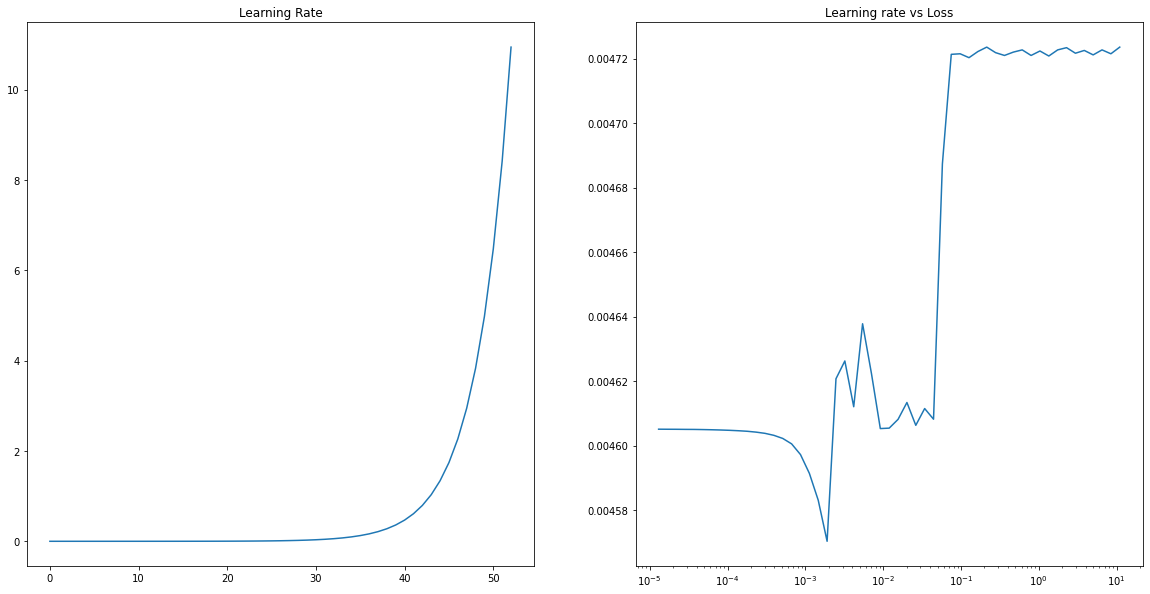

In [21]:
from Torch_CV_Utils.utils import lr_range_test
lr_range_test.plot_lrs(lrs,test_losses)

In [22]:
del test_losses, lrs

## Learning Rate Range Test - pytorch-lightning

In [9]:
from Torch_CV_Utils.utils import fastai_lr_range_test
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = config['standard_lr'], weight_decay = config['L2_penalty'])
lr_finder = fastai_lr_range_test.range_test(model, optimizer, criterion, device, trainloader, testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1/98]   1%|1          [00:00<?]

/usr/local/lib/python3.7/dist-packages/ignite/handlers/lr_finder.py:185: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  UserWarning,


[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

[1/98]   1%|1          [00:00<?]

{'acc': 0.4904, 'loss': 1.968466796875}


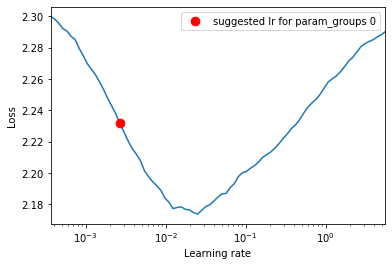

In [10]:
lr_finder.plot()

In [11]:
lr_finder.lr_suggestion()

0.002682695795279725

## Trigger Training

In [12]:
#config['standard_lr'] = 0.001
config['standard_lr'] = lr_finder.lr_suggestion()
print(config['standard_lr'])

0.002682695795279725


In [14]:
train_acc, train_losses, test_acc, test_losses, lrs = main.trigger_training(model, device, trainloader, testloader, config, optimizer_name = "Adam", scheduler_name = "OneCycle", criterion_name = "CrossEntropyLoss", lambda_l1 = 0, epochs = 24)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.8810629844665527 Batch_id=97 LR=0.00037 Accuracy=44.06: 100%|██████████| 98/98 [00:15<00:00,  6.24it/s]



Test set: Average loss: 0.0040, Accuracy: 4566/10000 (45.66%)

EPOCH: 2


Loss=1.7911227941513062 Batch_id=97 LR=0.00107 Accuracy=60.97: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.0037, Accuracy: 6156/10000 (61.56%)

EPOCH: 3


Loss=1.7530632019042969 Batch_id=97 LR=0.00189 Accuracy=69.41: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.0037, Accuracy: 6238/10000 (62.38%)

EPOCH: 4


Loss=1.6939486265182495 Batch_id=97 LR=0.00251 Accuracy=72.38: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.0036, Accuracy: 6455/10000 (64.55%)

EPOCH: 5


Loss=1.6740559339523315 Batch_id=97 LR=0.00268 Accuracy=75.99: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.0034, Accuracy: 7676/10000 (76.76%)

EPOCH: 6


Loss=1.6826244592666626 Batch_id=97 LR=0.00266 Accuracy=78.70: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.0034, Accuracy: 7360/10000 (73.60%)

EPOCH: 7


Loss=1.6443225145339966 Batch_id=97 LR=0.00260 Accuracy=80.54: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.0034, Accuracy: 7565/10000 (75.65%)

EPOCH: 8


Loss=1.660696268081665 Batch_id=97 LR=0.00250 Accuracy=81.77: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.0033, Accuracy: 7983/10000 (79.83%)

EPOCH: 9


Loss=1.6140000820159912 Batch_id=97 LR=0.00238 Accuracy=82.87: 100%|██████████| 98/98 [00:15<00:00,  6.24it/s]



Test set: Average loss: 0.0033, Accuracy: 7945/10000 (79.45%)

EPOCH: 10


Loss=1.6176668405532837 Batch_id=97 LR=0.00222 Accuracy=84.34: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.0033, Accuracy: 8120/10000 (81.20%)

EPOCH: 11


Loss=1.6293424367904663 Batch_id=97 LR=0.00205 Accuracy=85.53: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.0033, Accuracy: 8304/10000 (83.04%)

EPOCH: 12


Loss=1.5810519456863403 Batch_id=97 LR=0.00185 Accuracy=86.44: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.0032, Accuracy: 8361/10000 (83.61%)

EPOCH: 13


Loss=1.5949000120162964 Batch_id=97 LR=0.00164 Accuracy=87.61: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 0.0032, Accuracy: 8526/10000 (85.26%)

EPOCH: 14


Loss=1.5578066110610962 Batch_id=97 LR=0.00143 Accuracy=89.05: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s]



Test set: Average loss: 0.0032, Accuracy: 8653/10000 (86.53%)

EPOCH: 15


Loss=1.5586748123168945 Batch_id=97 LR=0.00121 Accuracy=89.49: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.0032, Accuracy: 8693/10000 (86.93%)

EPOCH: 16


Loss=1.5678797960281372 Batch_id=97 LR=0.00099 Accuracy=90.53: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.0032, Accuracy: 8815/10000 (88.15%)

EPOCH: 17


Loss=1.532879114151001 Batch_id=97 LR=0.00079 Accuracy=91.43: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.0031, Accuracy: 8868/10000 (88.68%)

EPOCH: 18


Loss=1.5467233657836914 Batch_id=97 LR=0.00059 Accuracy=92.33: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.0031, Accuracy: 8928/10000 (89.28%)

EPOCH: 19


Loss=1.540803074836731 Batch_id=97 LR=0.00042 Accuracy=92.92: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.0031, Accuracy: 9000/10000 (90.00%)

EPOCH: 20


Loss=1.5131628513336182 Batch_id=97 LR=0.00028 Accuracy=93.71: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.0031, Accuracy: 9016/10000 (90.16%)

EPOCH: 21


Loss=1.5177315473556519 Batch_id=97 LR=0.00016 Accuracy=94.13: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.0031, Accuracy: 9035/10000 (90.35%)

EPOCH: 22


Loss=1.5127336978912354 Batch_id=97 LR=0.00007 Accuracy=94.41: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]



Test set: Average loss: 0.0031, Accuracy: 9055/10000 (90.55%)

EPOCH: 23


Loss=1.5245492458343506 Batch_id=97 LR=0.00002 Accuracy=94.51: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.0031, Accuracy: 9056/10000 (90.56%)

EPOCH: 24


Loss=1.496837854385376 Batch_id=97 LR=0.00000 Accuracy=94.59: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.0031, Accuracy: 9063/10000 (90.63%)



## Plot Metrics

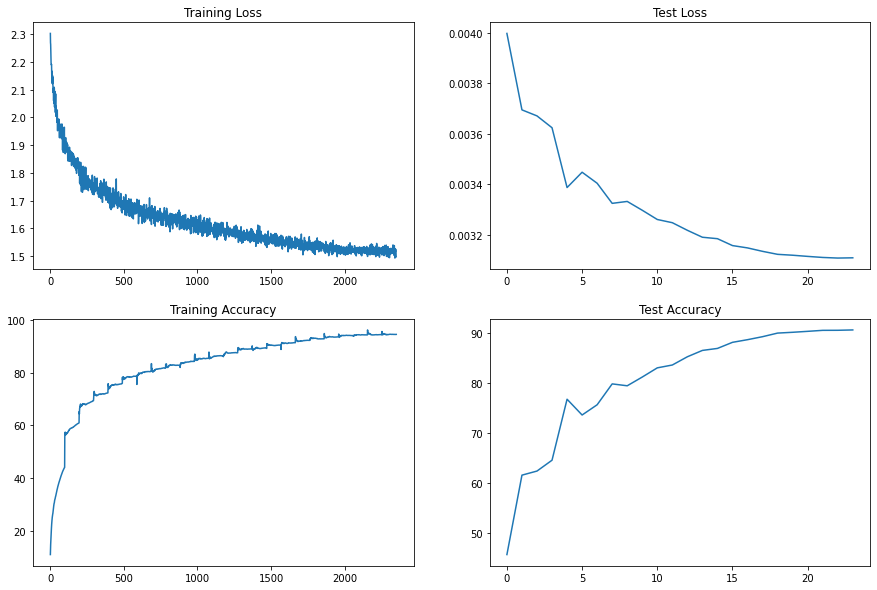

In [15]:
helpers.plot_metrics(train_acc, train_losses, test_acc, test_losses)

## Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 937


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


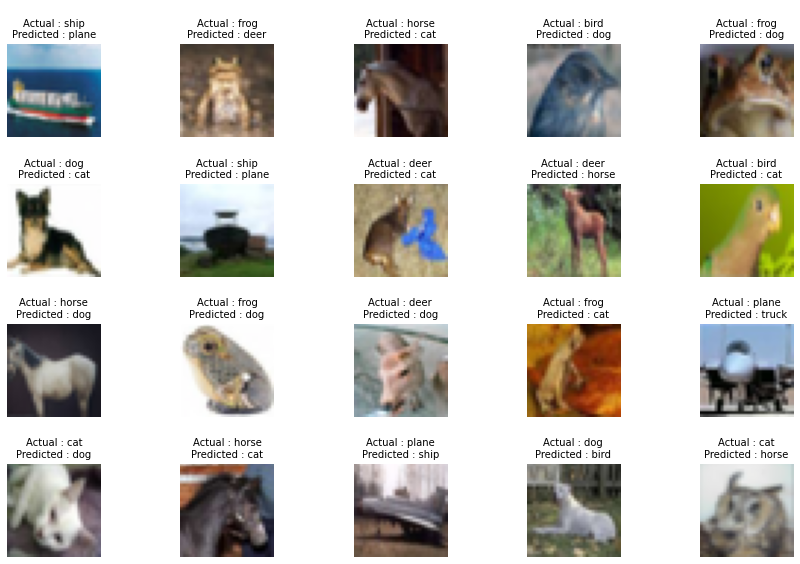

In [16]:
misclassified_images = helpers.wrong_predictions(model, testloader, device)
helpers.plot_misclassified(misclassified_images, mean, std, 20)

## Gradcam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM @layer3


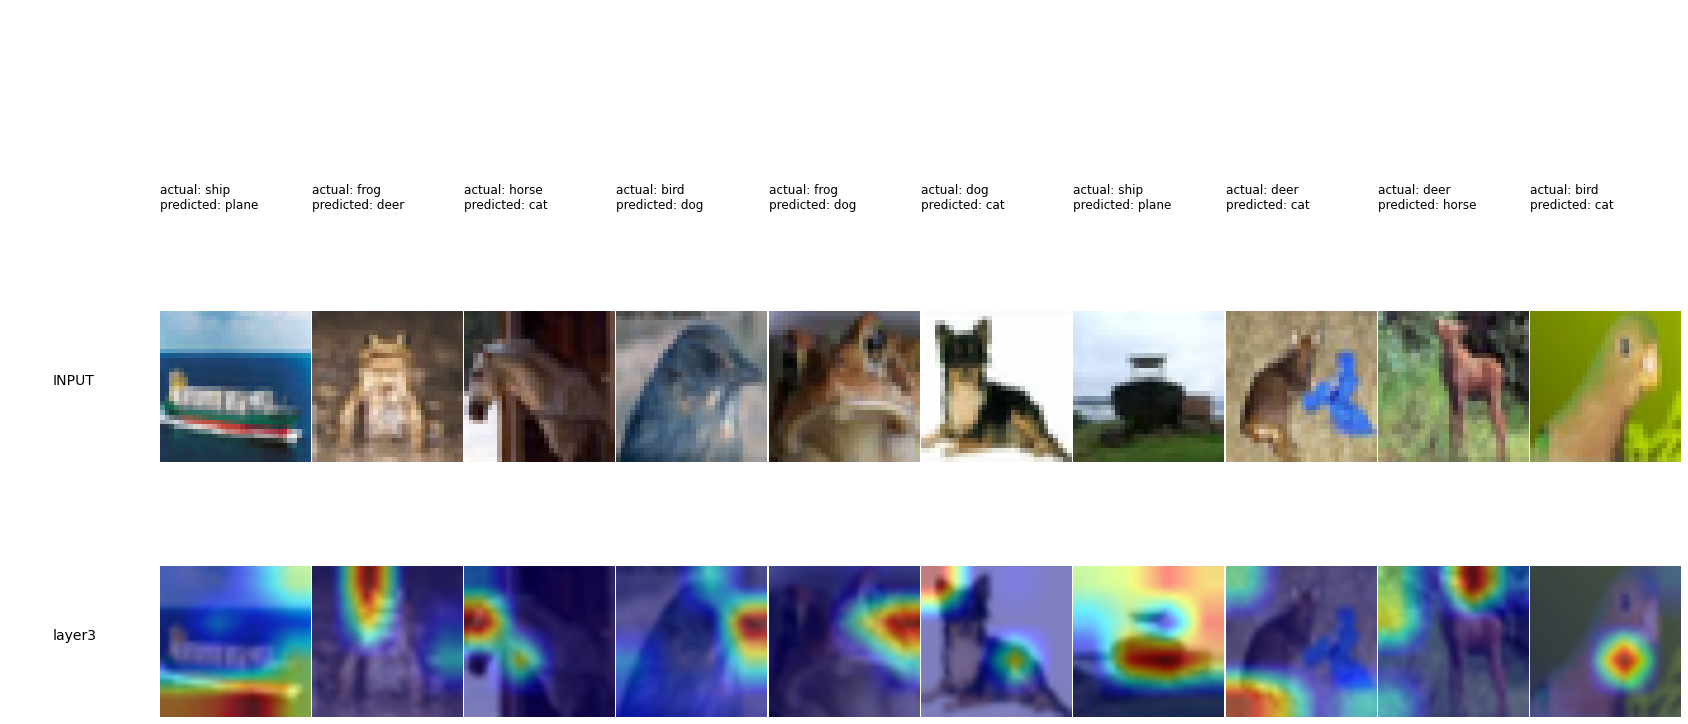

In [17]:
target_layers = ["layer3"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[:10], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10], mean, std)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM @layer3


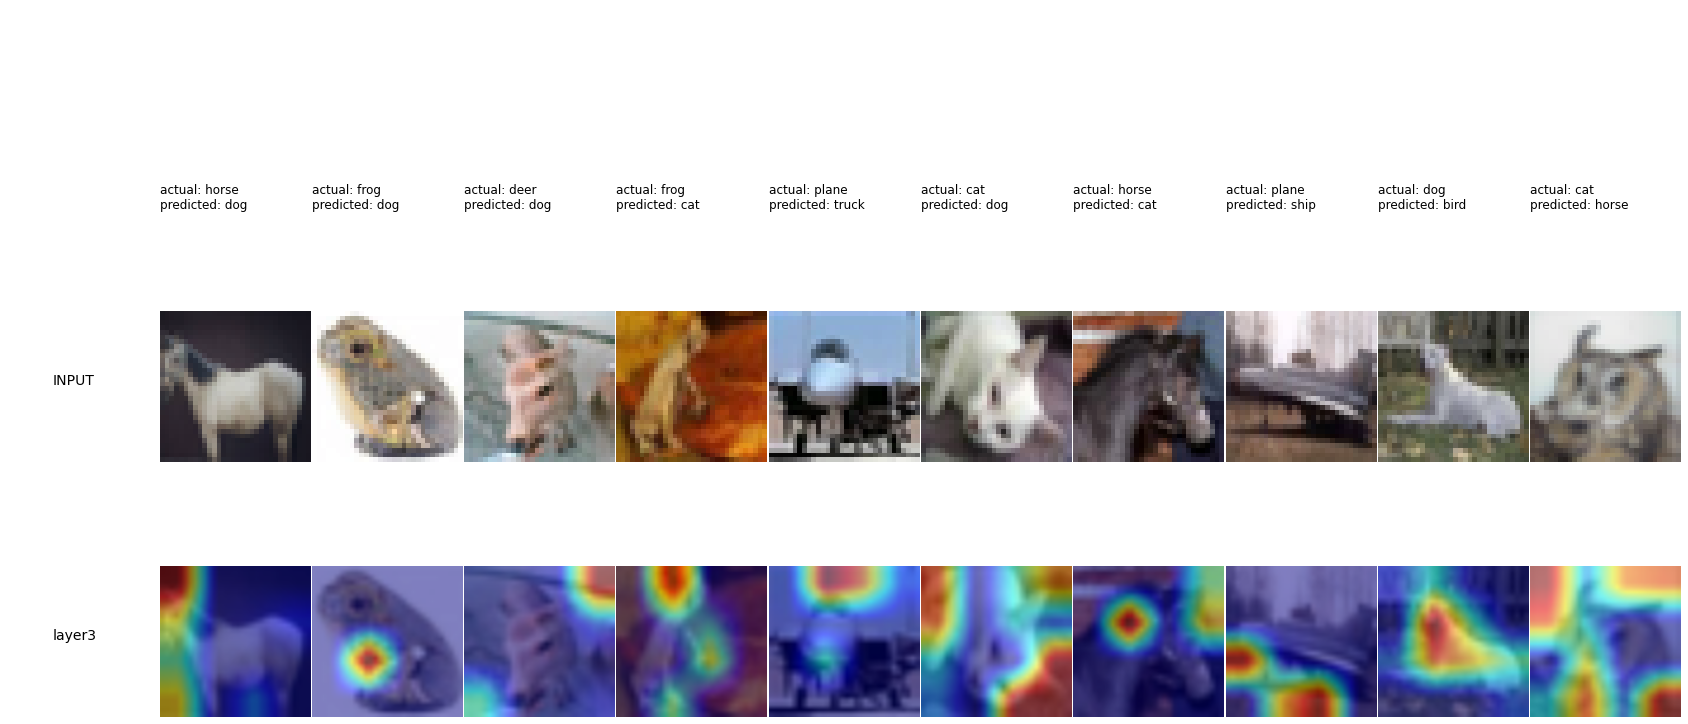

In [18]:
target_layers = ["layer3"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[10:20], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[10:20], mean, std)